In [1]:
# Usehttp://localhost:8888/notebooks/work/toolkit/caseStudy.ipynb#First,-we-gather-the-dataset.-This-is-a-history-of-static-code-metrics-(C-and-indentation)-and-change-metrics-for-our-project.d to access the toolkit modules in this directory
import toolkit

### First, we gather the dataset. This is a history of static code metrics (C and indentation) and change metrics for our project.

In [2]:
# Used to indicate where the data should be gathered and stored
rootDirectory = '../dataSets/gitStudy/'

# Call gatherTimeMetrics and measure C, Indent and Change metrics 
# on .c and .h files from the git project's repository
metricsData = toolkit.data.gatherTimeMetrics(rootDirectory, 'https://github.com/git/git', rootDirectory+'git/', '*/*.c */*.h *.c *.h', ['indent','c'], skipEvery=50)

### How many times did we sample from?
### How many features and samples are in our dataset?
### How many unique source files were measured?

In [3]:
print metricsData['times']
print metricsData['data'].shape
print metricsData['data']['entity'].nunique()
print

307
(11227, 64)
467



In [4]:
print metricsData['data'].head

<bound method DataFrame.head of                         entity  age-months  n-authors  n-revs  added  deleted  \
0                     pretty.c           0          2       3     88       16   
1                     config.c           0          3       6     56       22   
2                   revision.c           0          3       8     34       81   
3                     commit.h           0          2       2      2        1   
4                   revision.h           0          3       5      7       12   
5                  wt-status.c           0          3       3      5        7   
6                        dir.h           1          4       6      9        8   
7                     strbuf.c           1          3       7     52        7   
8                  submodule.h           1          1       3     19        1   
9   credential-cache--daemon.c           1          3       5     37       18   
10                    remote.c           1          4       6     46       56

### Let's see what affects the net churn of files 
### Which types of files have net churn above and below the mean net churn?

Response variable was netchurn
Model.score: 0.210620
accuracy_score: 0.210620
             precision    recall  f1-score   support

      -3673       0.00      0.00      0.00         1
      -3670       0.00      0.00      0.00         1
      -3561       0.00      0.00      0.00         1
      -2477       0.00      0.00      0.00         3
      -2402       0.00      0.00      0.00         2
      -2393       0.00      0.00      0.00         1
      -1451       0.00      0.00      0.00         2
      -1447       0.00      0.00      0.00         2
      -1363       0.00      0.00      0.00         1
      -1349       0.00      0.00      0.00         1
      -1345       0.00      0.00      0.00         1
      -1344       0.00      0.00      0.00         2
      -1320       0.00      0.00      0.00         1
      -1312       0.00      0.00      0.00         1
      -1310       0.00      0.00      0.00         1
      -1292       0.00      0.00      0.00         2
      -1279       0.

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


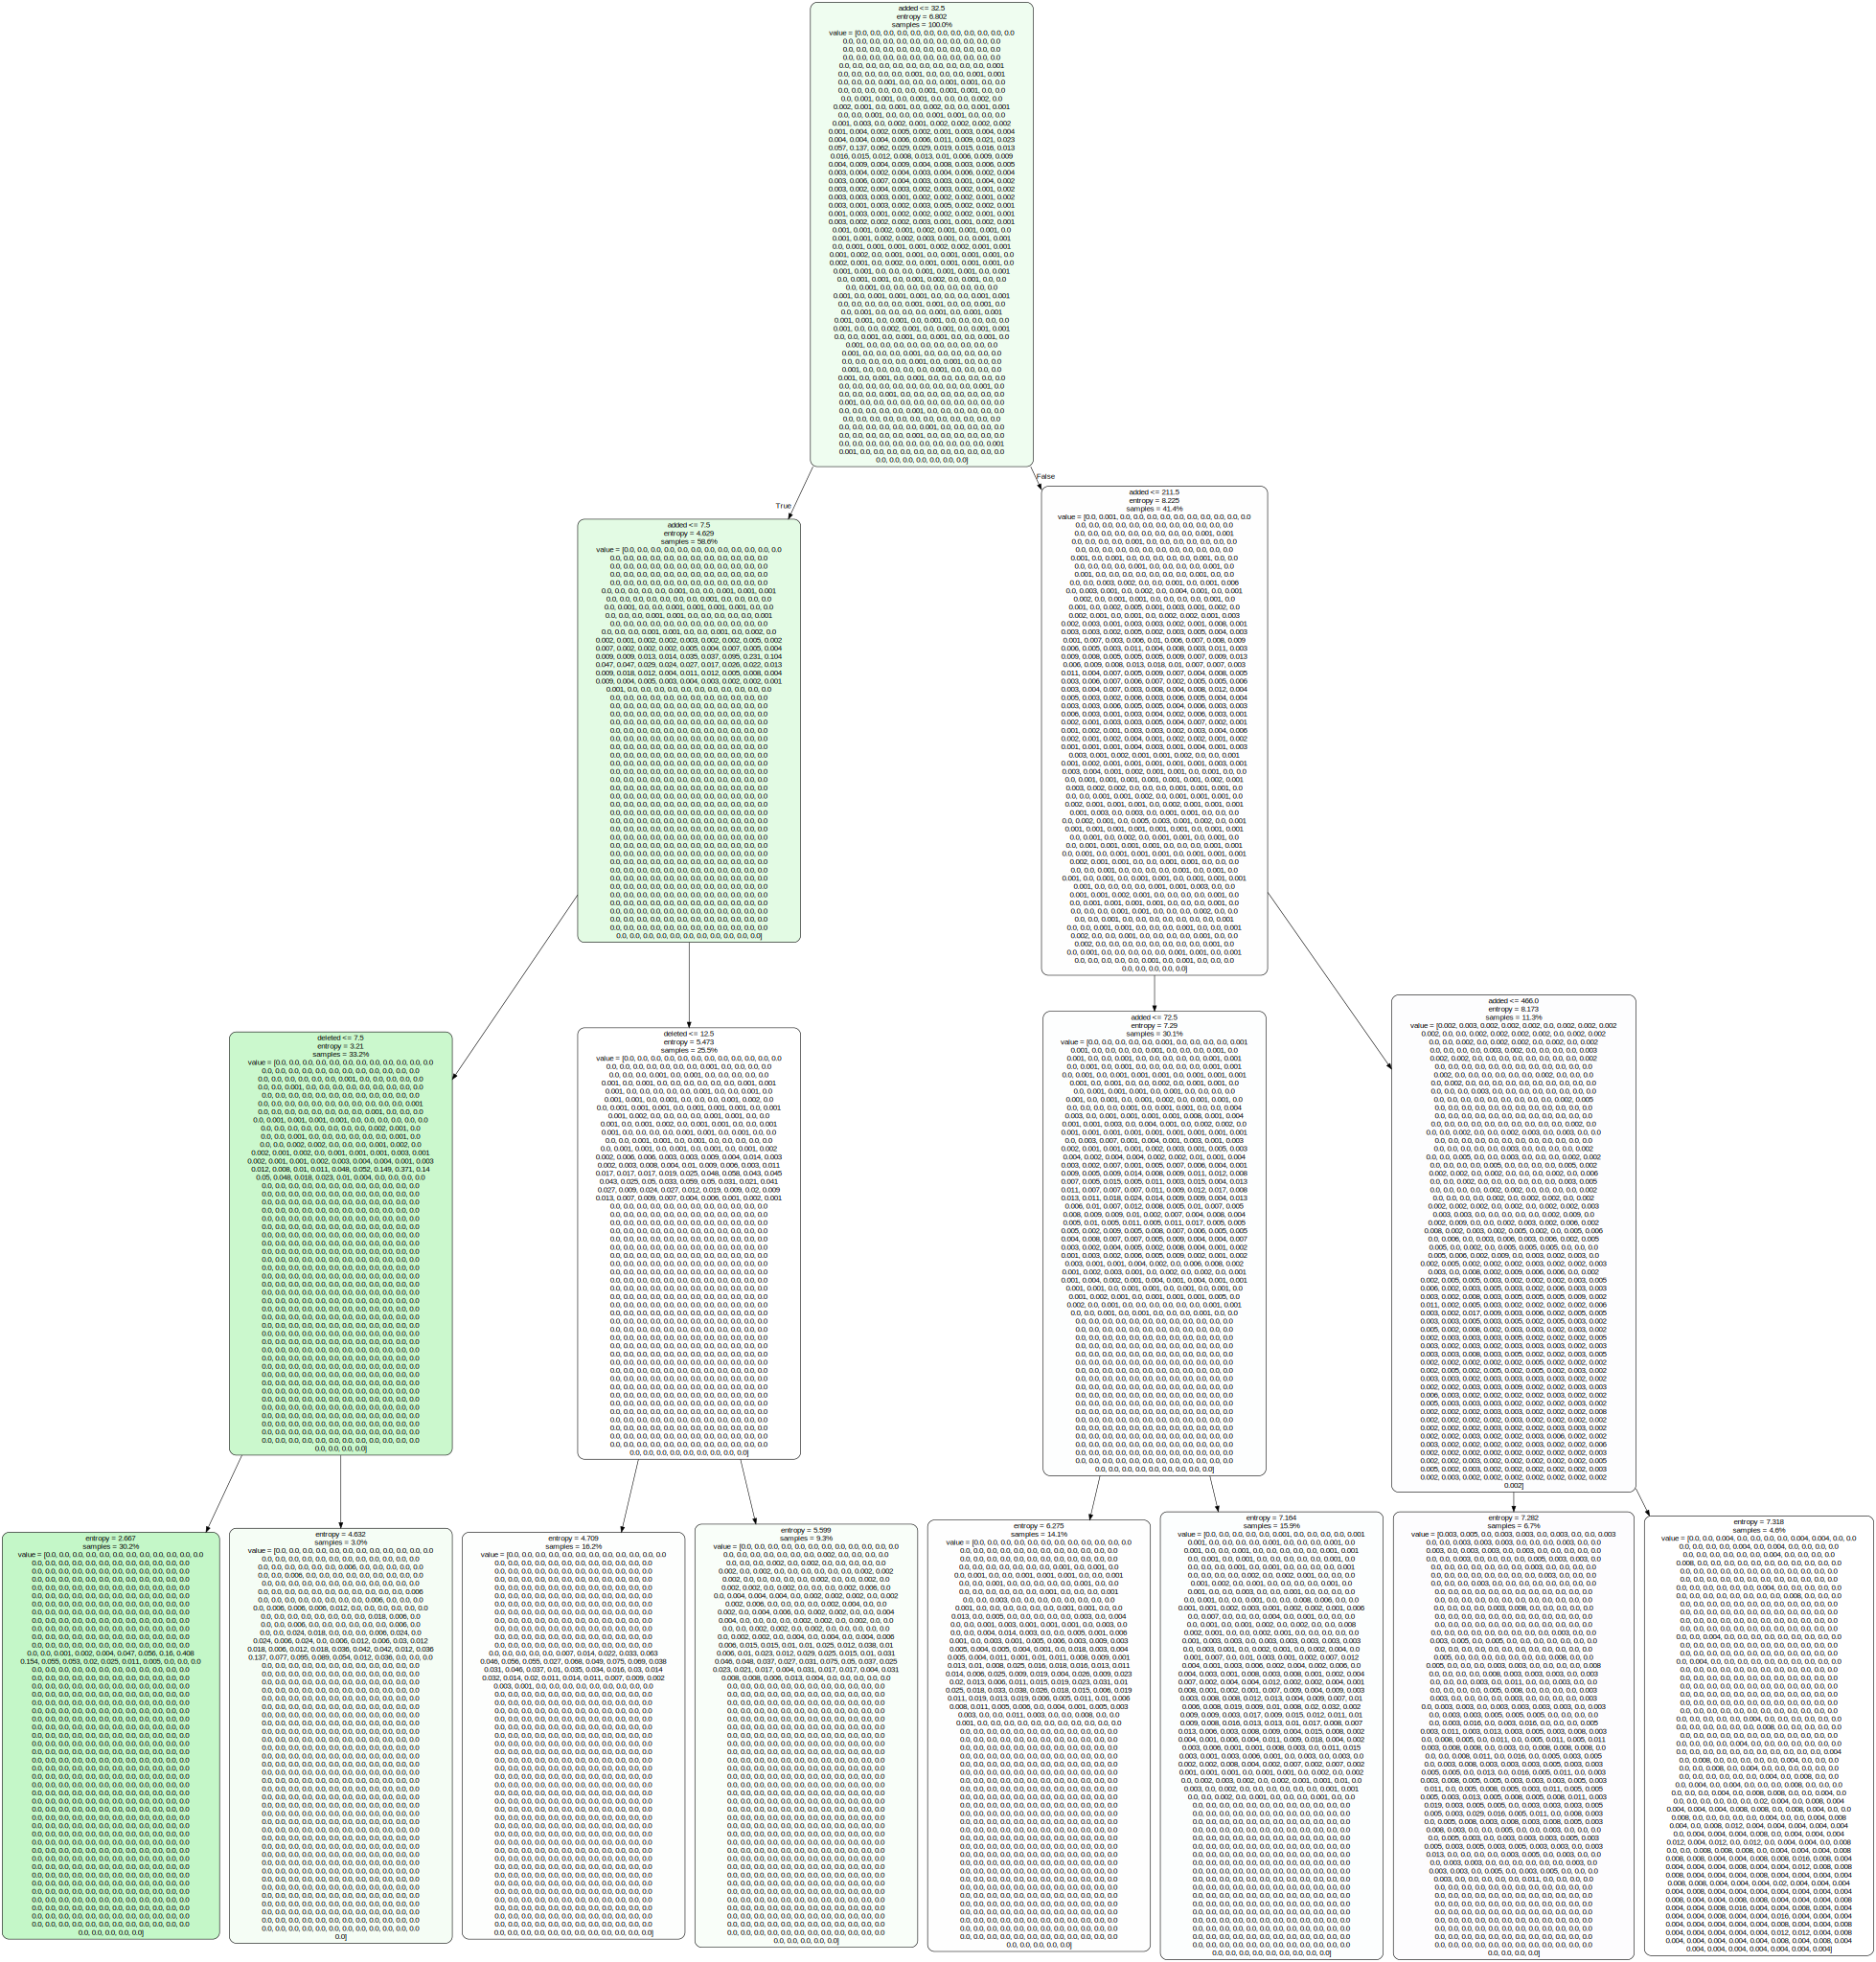

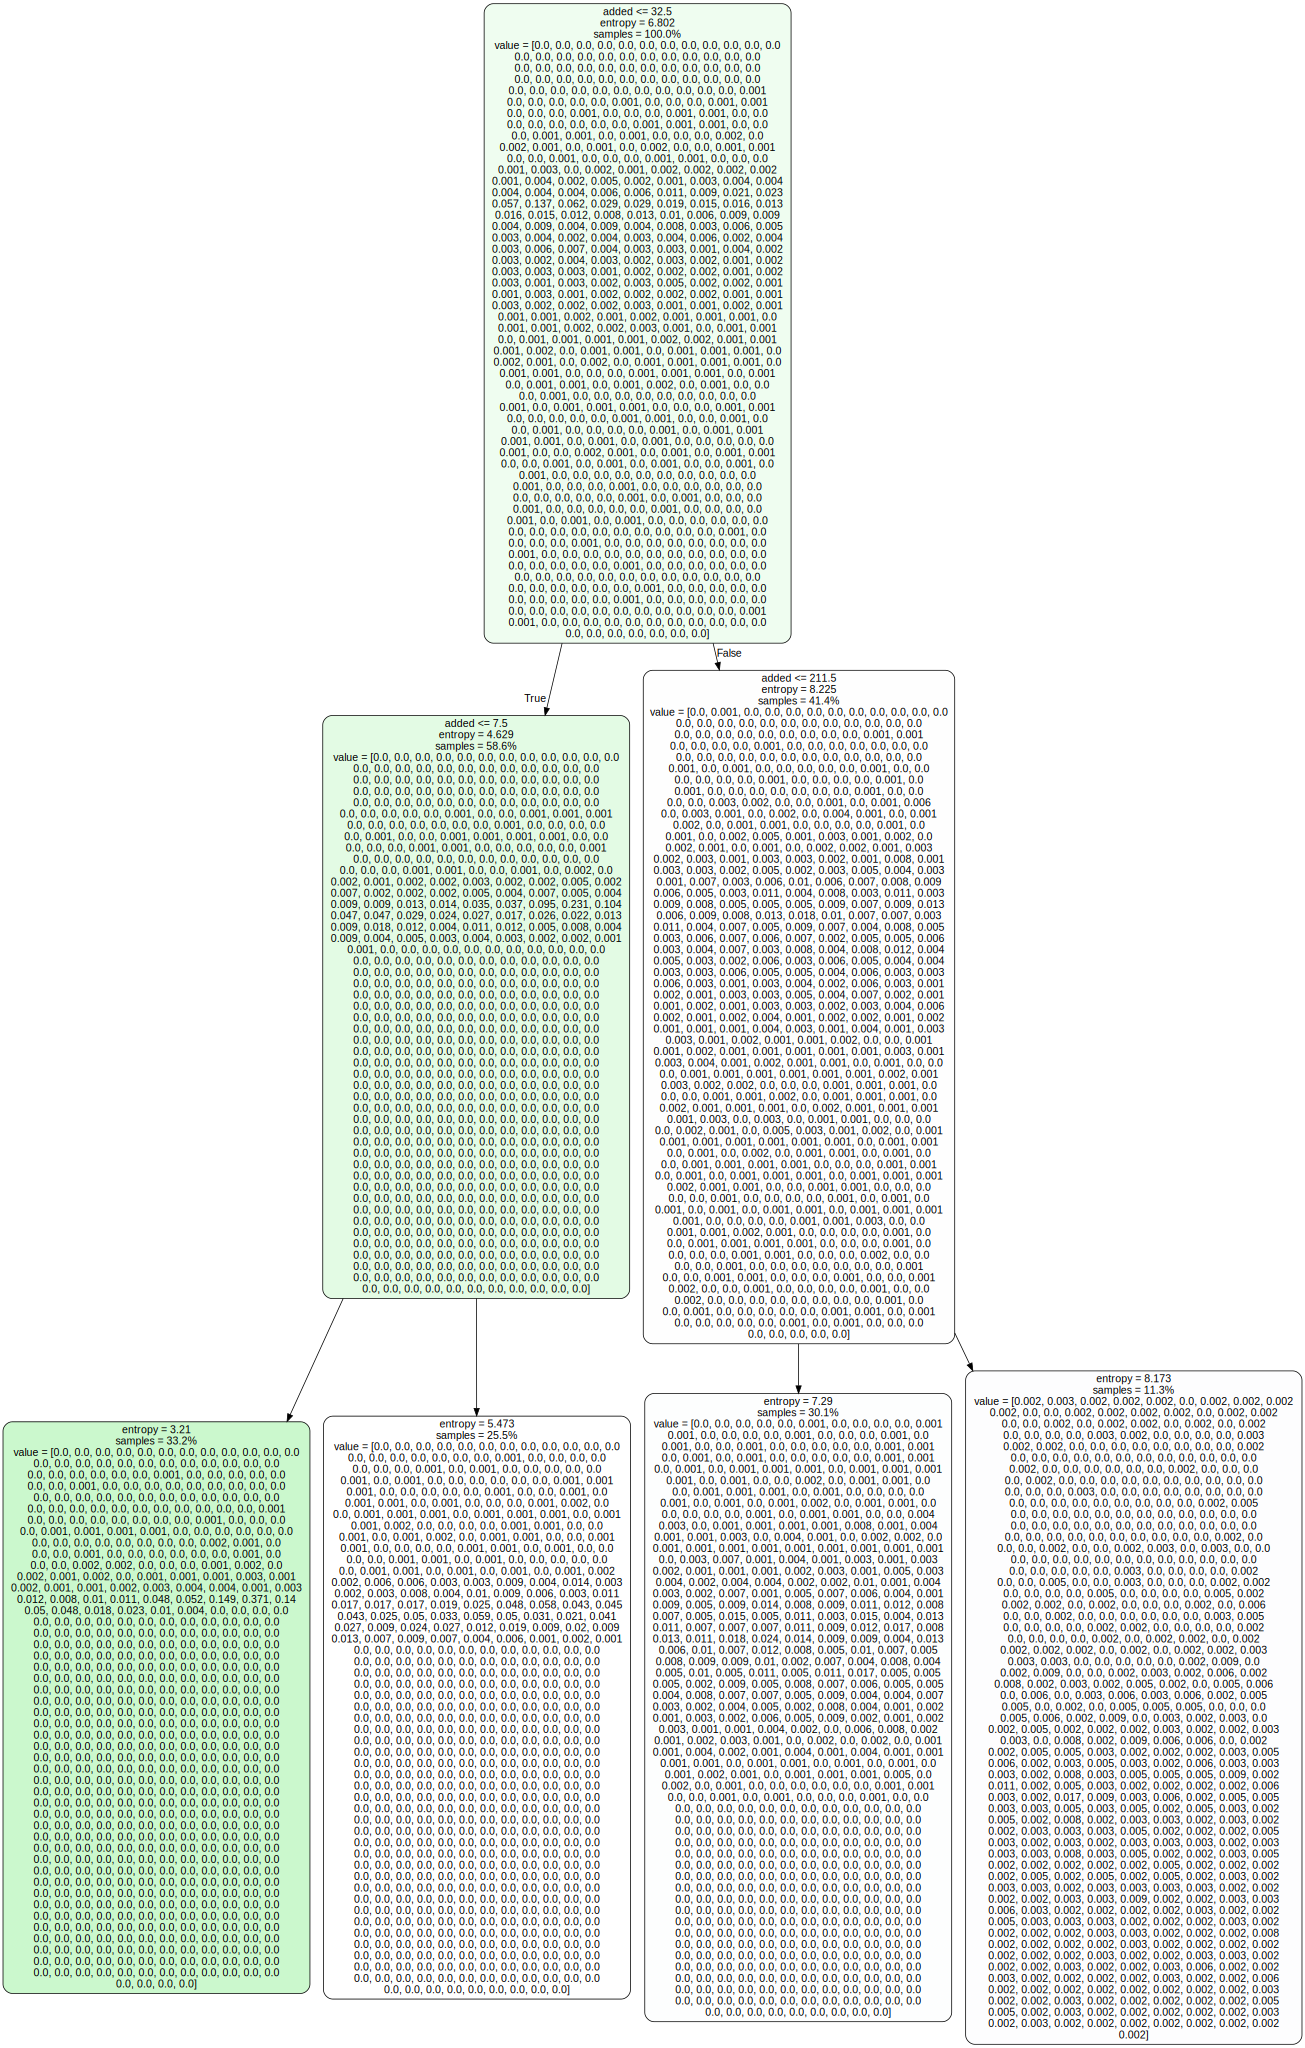

In [5]:
# We instantiate the scikit-learn decision tree classification model
# It is trained with a maximum number of leaf nodes
# Samples are binned so as to maximize information gain at higher nodes ('entropy')
from sklearn.tree import DecisionTreeClassifier
modelInstance = DecisionTreeClassifier(max_leaf_nodes=8, criterion='entropy')
modelSimpler = DecisionTreeClassifier(max_leaf_nodes=4, criterion='entropy')
churnModel = toolkit.refinement.makeAndUpdateModel(rootDirectory, metricsData['data'], 2, 'netchurn', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### Some observations:
- The model has very good Precision, Recall and F1-Score: net churn above/below the mean is classified very well by this model
- ROC area under curve is very high: very little compromise between false negative rate and false positive rate
- The model says that the features influencing net churn are (strongest to weakest):
    - Number of lines added
    - Number of lines deleted    
- The 'net churn below the mean' class is over-represented in our data (3 times as many samples as the other class)
    - However, the model still performs well without any steps taken to address class imbalance (e.g. under/over-sampling)
- Interpretation of the visualized decision tree is straightforward:
    - 63% of samples were files with less than 34 lines added 
        - These samples had net churn less than the mean
        - Some of these may be very stable files (over the history of the project)
    - The files with net churn greater than the mean had more than 108 lines added
    - Within this group, there are several subgroups with varying levels of churn

### In the above step, we only performed 2-fold cross validation (1 training set, 1 test set)

### How does this approach perform with more cross-validation folds in time?

In [6]:
# We split the data into 5 equally-sized groups, 
# then perform cross-validation while gradually adding these groups to the training set

# i.e. the train-test splits are with groups of size:
# 1-4, 2-3, 3-2, 4-1

# We omit visualization of decision trees to save space,
# but they can be shown with visualize=True as above
folds = 5
churnModelMoreFolds = toolkit.refinement.makeAndUpdateModel(rootDirectory, metricsData['data'], folds, 'netchurn', modelInstance, modelSimpler, scoreOnly=False) 

Response variable was netchurn
Model.score: 0.960784
accuracy_score: 0.960784
             precision    recall  f1-score   support

          0       0.99      0.95      0.97      1577
          1       0.89      0.99      0.94       667

avg / total       0.96      0.96      0.96      2244

roc_auc_score: 0.968638
    name  importance
3  added    0.837169
Model.score: 0.940285
accuracy_score: 0.940285
             precision    recall  f1-score   support

          0       0.98      0.93      0.95      1433
          1       0.88      0.96      0.92       811

avg / total       0.94      0.94      0.94      2244

roc_auc_score: 0.944949
    name  importance
3  added    0.881516
Model.score: 0.946524
accuracy_score: 0.946524
             precision    recall  f1-score   support

          0       0.98      0.95      0.97      1808
          1       0.83      0.91      0.87       436

avg / total       0.95      0.95      0.95      2244

roc_auc_score: 0.933745
    name  importance
3  add

### Each of the subsets still exhibits class imbalance (but not with the same ratio)
### In particular, the 2nd train-test split has the most balanced classes (2:1) among the five splits

### We still see very good performance, and the same features are important throughout
### How far can we go? Let's cross-validate on every sampled time!

In [7]:
folds = metricsData['times'] # This is an attribute of the measured data set: the number of time points measured
#churnModelMoreFolds = toolkit.refinement.makeAndUpdateModel(rootDirectory, metricsData['data'], folds, 'netchurn', modelInstance, scoreOnly=False) 

### Results of this step are omitted for printing. However, the large cross-validation can be run to see them.

### The individual data sets used for training and testing are quite small and imbalanced.

### Many of the same relationships still show up.

### Why is 'added' a much more important factor than 'deleted'? 

In [8]:
print metricsData['data']['netchurn'].mean()
print metricsData['data']['netchurn'].var()
print metricsData['data']['netchurn'].std()
print metricsData['data']['netchurn'].max()
print metricsData['data']['netchurn'].min()

22.320744633472877
39089.24425428246
197.71000039017363
2536
-3673


### This codebase is *growing* in general (more added than deleted)

### Some files must experience more churn than others. We know from some of the motivating literature that defects can be correlated with large pre-release churn.

### Let's make some categories of binned churn data and classify them 

Response variable was ['churnLow', 'churnMedium', 'churnHigh', 'churnHigher', 'churnHighest']
Model.score: 0.973806
accuracy_score: 0.973806
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       0.00      0.00      0.00        20
          2       0.99      0.99      0.99      4792
          3       0.91      0.94      0.92       787
          4       0.00      0.00      0.00         7

avg / total       0.97      0.97      0.97      5612

roc_auc_score: 0.682604
    name  importance
3  added    0.847693
Model.score: 0.956522
accuracy_score: 0.956522
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       0.00      0.00      0.00        20
          2       0.97      0.99      0.98      4792
          3       0.89      0.82      0.85       787
          4       0.00      0.00      0.00         7

avg / total       0.95      0.96      0.95      5612

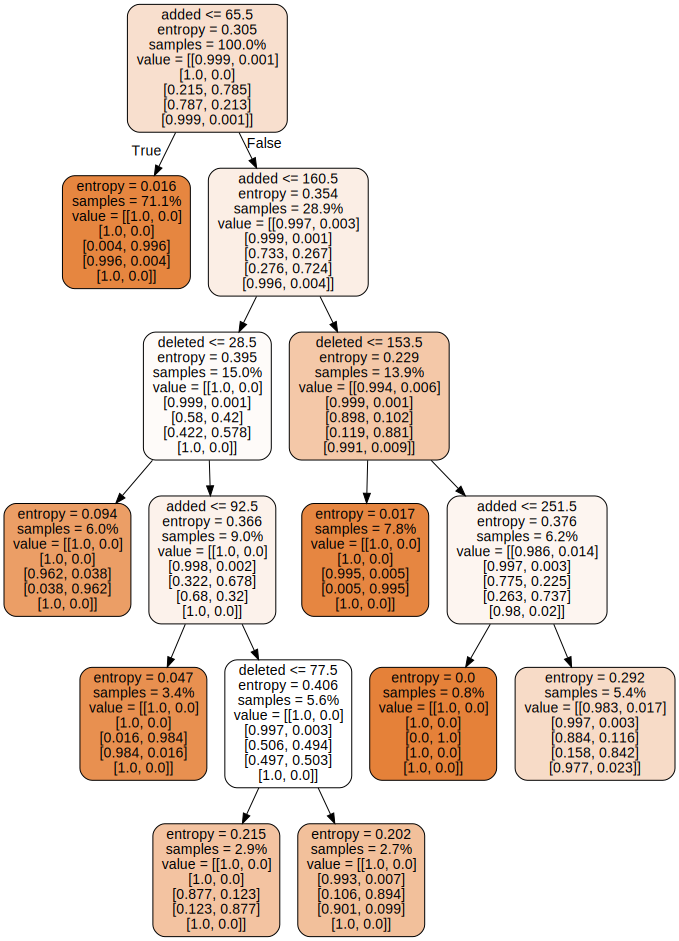

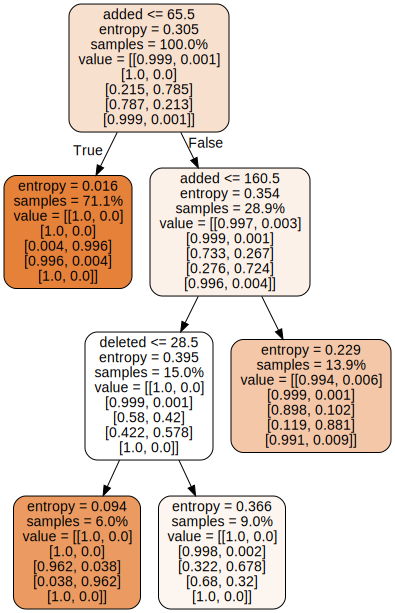

In [9]:
churnBinnedCategories = ['churnLow','churnMedium','churnHigh','churnHigher', 'churnHighest']
dataSetUpdated = toolkit.utilities.addBinnedResponseCategory(metricsData['data'], 'netchurn', churnBinnedCategories)

from sklearn.tree import DecisionTreeClassifier
modelInstance = DecisionTreeClassifier(max_leaf_nodes=8, criterion='entropy')
churnModelCategories = toolkit.refinement.makeAndUpdateModel(rootDirectory, dataSetUpdated, 2, churnBinnedCategories, modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### Now we're seeing something interesting. The vast majority of the files exhibit very low amounts of churn. A select few files receive most of the lines added/deleted. Does the class imbalance impact the validity of this model? Let's try more cross-validation to see.

Response variable was ['churnLow', 'churnMedium', 'churnHigh', 'churnHigher', 'churnHighest']
Model.score: 0.959369
accuracy_score: 0.959369
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         8
          1       0.00      0.00      0.00        16
          2       0.96      0.99      0.98      2865
          3       0.95      0.89      0.92       848
          4       0.00      0.00      0.00         4

avg / total       0.95      0.96      0.96      3741

roc_auc_score: 0.673949
    name  importance
3  added    0.868373
Model.score: 0.969794
accuracy_score: 0.969794
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.50      0.67         6
          2       0.99      0.98      0.98      3248
          3       0.84      0.94      0.89       480
          4       0.00      0.00      0.00         7

avg / total       0.97      0.97      0.97      3741

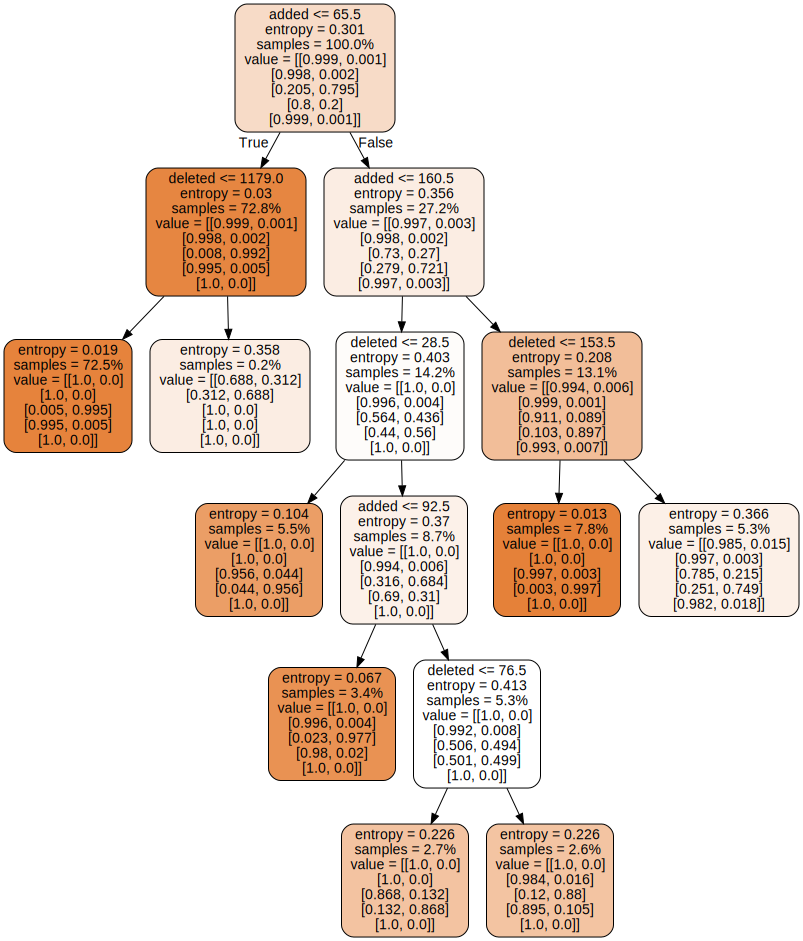

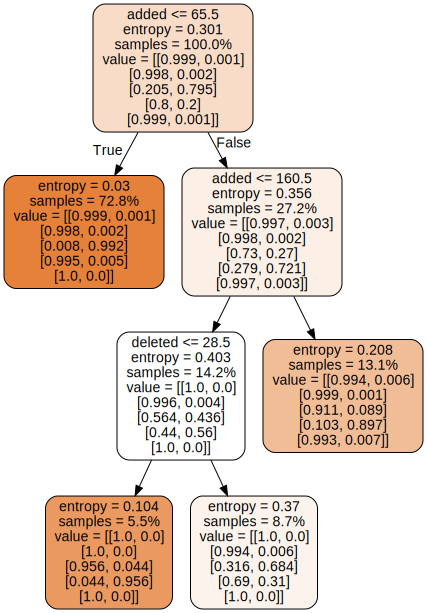

In [10]:
folds = 3
churnModelCategories = toolkit.refinement.makeAndUpdateModel(rootDirectory, dataSetUpdated, folds, churnBinnedCategories, modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### Let's look at this from another point of view. What characterises the files which have the most lines added?

Response variable was added
Model.score: 0.970064
accuracy_score: 0.970064
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      4582
          1       0.95      0.89      0.92      1030

avg / total       0.97      0.97      0.97      5612

roc_auc_score: 0.938015
       name  importance
6  netchurn    0.673289
3   deleted    0.300639
Model.score: 0.907520
accuracy_score: 0.907520
             precision    recall  f1-score   support

          0       0.99      0.90      0.94      4582
          1       0.68      0.95      0.79      1030

avg / total       0.93      0.91      0.91      5612

roc_auc_score: 0.925679
       name  importance
2  netchurn    0.723155
1   deleted    0.276845


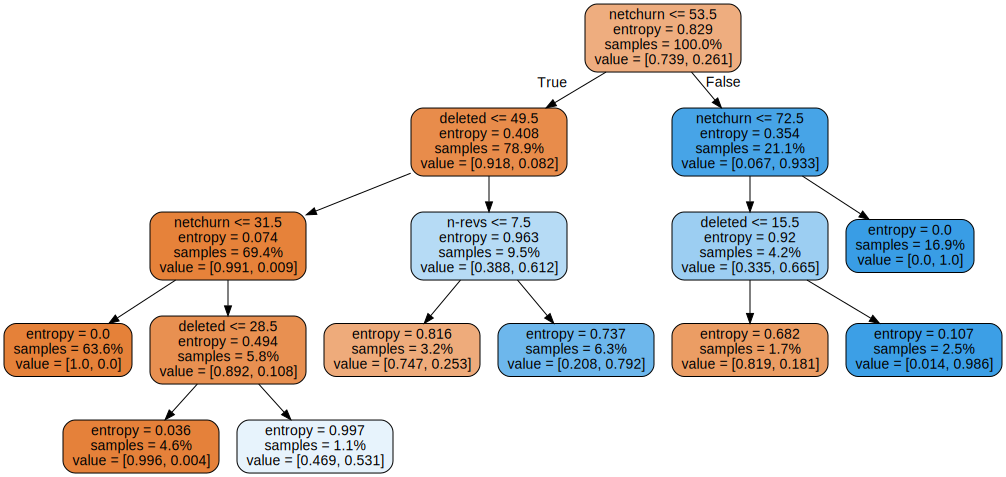

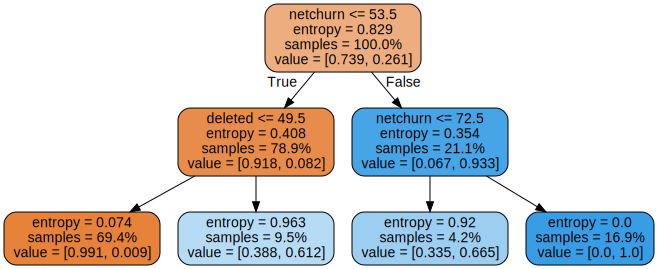

In [11]:
addedModel = toolkit.refinement.makeAndUpdateModel(rootDirectory, metricsData['data'], 2, 'added', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### Net churn and deleted lines are strongly related. What do we find if we're not allowed to use these in our decision tree?

Response variable was added
Model.score: 0.885780
accuracy_score: 0.885780
             precision    recall  f1-score   support

          0       0.90      0.97      0.93      4582
          1       0.80      0.51      0.62      1030

avg / total       0.88      0.89      0.88      5612

roc_auc_score: 0.738885
     name  importance
2  n-revs    0.878641
Model.score: 0.874911
accuracy_score: 0.874911
             precision    recall  f1-score   support

          0       0.90      0.95      0.93      4582
          1       0.72      0.52      0.61      1030

avg / total       0.87      0.87      0.87      5612

roc_auc_score: 0.738626
     name  importance
0  n-revs         1.0


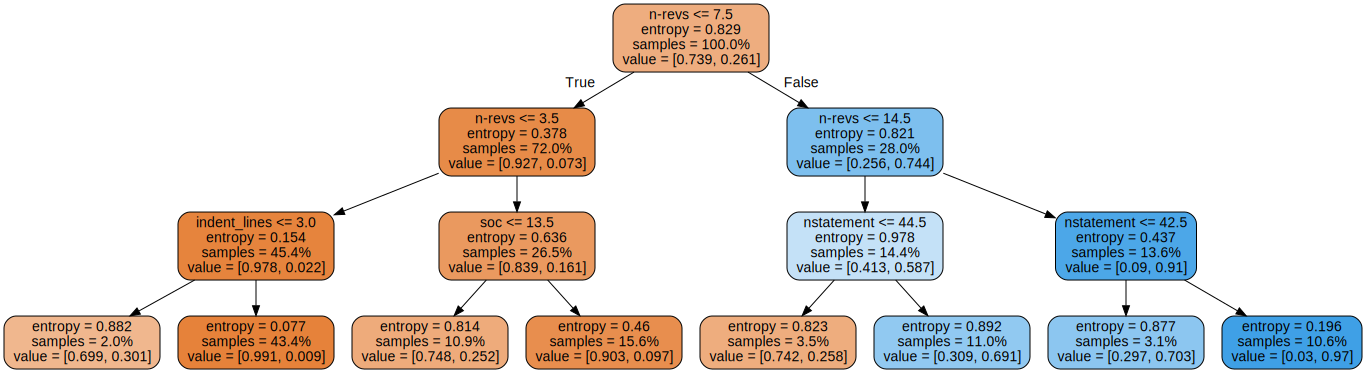

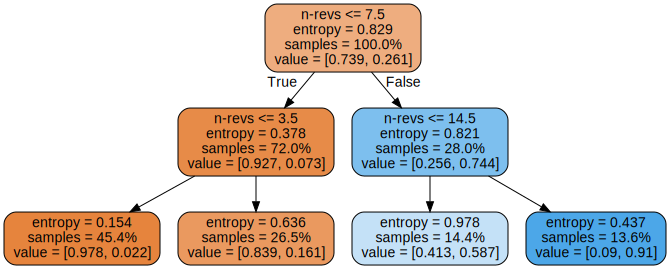

In [12]:
alteredData = metricsData['data'].drop(['netchurn','deleted'], axis=1)
addedModel = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData, 2, 'added', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### The model uses n-revs as the most important feature, but it does not classify '# lines added above the mean' very well

Response variable was added
Model.score: 0.843728
accuracy_score: 0.843728
             precision    recall  f1-score   support

          0       0.86      0.97      0.91      4582
          1       0.69      0.27      0.39      1030

avg / total       0.83      0.84      0.81      5612

roc_auc_score: 0.621687
        name  importance
1  n-authors    0.738386
Model.score: 0.834818
accuracy_score: 0.834818
             precision    recall  f1-score   support

          0       0.86      0.96      0.90      4582
          1       0.61      0.29      0.39      1030

avg / total       0.81      0.83      0.81      5612

roc_auc_score: 0.621876
        name  importance
0  n-authors    0.873184


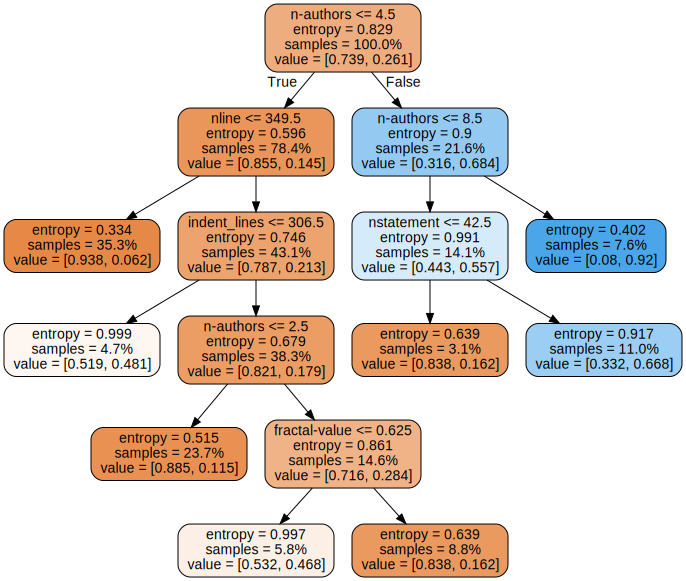

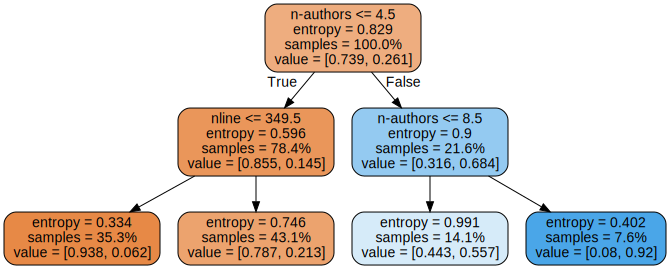

In [13]:
alteredData2 = metricsData['data'].drop(['netchurn','deleted','n-revs'], axis=1)
addedModel2 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData2, 2, 'added', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### n-authors has similar problems with identifying the minority class

Response variable was added
Model.score: 0.812010
accuracy_score: 0.812010
             precision    recall  f1-score   support

          0       0.83      0.96      0.89      4582
          1       0.46      0.13      0.21      1030

avg / total       0.76      0.81      0.77      5612

roc_auc_score: 0.549580
            name  importance
1  fractal-value    0.552154
4          nline    0.192671
Model.score: 0.812545
accuracy_score: 0.812545
             precision    recall  f1-score   support

          0       0.83      0.97      0.89      4582
          1       0.46      0.12      0.19      1030

avg / total       0.76      0.81      0.76      5612

roc_auc_score: 0.544262
            name  importance
0  fractal-value    0.741321
2          nline    0.258679


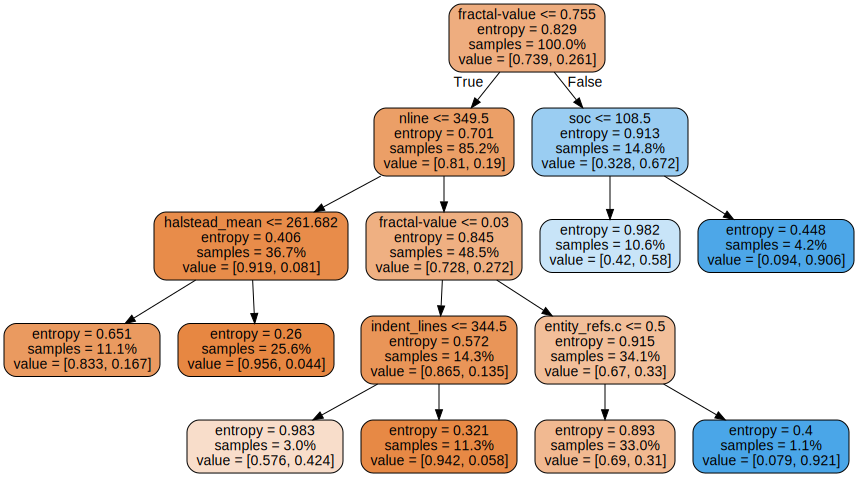

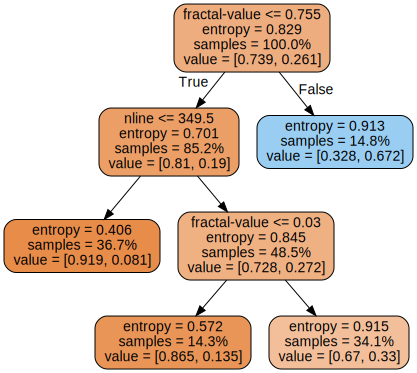

In [14]:
alteredData3 = metricsData['data'].drop(['netchurn','deleted','n-revs','n-authors'], axis=1)
addedModel3 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData3, 2, 'added', modelInstance, modelSimpler, visualize=True, scoreOnly=False) 

### fractal-value is derived from n-revs and n-authors

### Let's get rid of it and build a regression model for nline
### This model will predict the sizes of files based on their other static features

In [15]:
from sklearn.tree import DecisionTreeRegressor
modelInstanceR = DecisionTreeRegressor(max_leaf_nodes=8)
modelInstanceRsimpler = DecisionTreeRegressor(max_leaf_nodes=4)
alteredData4 = metricsData['data'].drop(['netchurn','deleted','n-revs','n-authors','fractal-value'], axis=1)
nlineModelR = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData4, 2, 'nline', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was nline
Model.score: 0.971510
            name  importance
51  indent_lines    0.961469
Model.score: 0.893328
           name  importance
1  indent_lines         1.0


### We see that the number of indented lines is a very good predictor of the number of lines

### Is the model using indent_lines because it is correlated with nline?

In [16]:
# We use the Spearman measure of rank correlation
metricsData['data']['nline'].corr(metricsData['data']['indent_lines'], method='spearman')

0.8899358711161287

### Let's remove indent_lines from this data set
### Are we still able to regress on nline (and with high performance)?

In [17]:
alteredData5 = metricsData['data'].drop(['indent_lines','nchar','nstatement','nidentifier'], axis=1)
nlineModelR2 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData5, 2, 'nline', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was nline
Model.score: 0.622293
         name  importance
18  ninternal    0.756306
Model.score: 0.635247
        name  importance
0  ninternal    0.817365


### cqmetrics provides several measures of the 'number of functions' contained in a file (each calculated differently)

### The model uses these to predict the size of files

In [18]:
alteredData6 = metricsData['data'].drop(['indent_lines','nchar','nstatement','nidentifier', 'nfunction','nfunction2','nfunction3'], axis=1)
nlineModelR3 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData6, 2, 'nline', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was nline
Model.score: 0.635695
         name  importance
17  ninternal     0.75984
Model.score: 0.635247
        name  importance
0  ninternal    0.817365


In [19]:
alteredData7 = metricsData['data'].drop(['indent_lines','nchar','nstatement','nidentifier', 'nfunction','nfunction2','nfunction3', 'unique_nidentifier'], axis=1)
nlineModelR4 = toolkit.refinement.makeAndUpdateModel(rootDirectory, alteredData7, 2, 'nline', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was nline
Model.score: 0.618105
         name  importance
17  ninternal    0.761305
Model.score: 0.635247
        name  importance
0  ninternal    0.817365


### Our regression model of nline needs the number of (unique) identifiers, and the number of functions in a file to explain the variance in our dataset

### Without these features, the model rapidly loses accuracy.

### From all the features we measure, the only ones which are strong predictors of size are other measures of such (which are bound to be correlated - lines of source code necessarily add identifiers, operators, functions etc as counted by Halstead's metrics)

### We see that the maximum Halstead complexity metric among the functions in each file is a (weak) predictor under this model. The measures from which it is calculated have a much stronger correlation with size.

### What about modelling these measures of complexity?

In [20]:
cycloData = metricsData['data'].drop(['cyclomatic_sd', 'cyclomatic_mean'], axis=1)
cycloModelR = toolkit.refinement.makeAndUpdateModel(rootDirectory, cycloData, 2, 'cyclomatic_max', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was cyclomatic_max
Model.score: 0.694034
            name  importance
47  halstead_max    0.865377
Model.score: 0.669826
           name  importance
3  halstead_max    0.945495


### Cyclomatic complexity seems to be similar to Halstead complexity for our dataset
### The measures which are used to derive both of these are also predictors. Let's remove them and repeat..

In [21]:
cycloData2 = metricsData['data'].drop(['halstead_sd','nidentifier','halstead_mean','halstead_min','cyclomatic_sd', 'cyclomatic_mean', 'halstead_max','nstatement','statement_nesting_mean'], axis=1)
cycloModelR = toolkit.refinement.makeAndUpdateModel(rootDirectory, cycloData2, 2, 'cyclomatic_max', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was cyclomatic_max
Model.score: 0.503687
           name  importance
8         nchar    0.522622
48  indent_mean    0.296906
Model.score: 0.374213
          name  importance
0        nchar    0.656162
4  indent_mean    0.221656


### The number of static variables and the mean indentation level of files are strong predictors of cyclomatic complexity for our dataset

### This indentation predictor is similar to the findings of Hindle. 
### What about the 'ninternal' (static linkage) result? The files containing functions with higher cyclomatic complexity also have more variables (which are shared between functions in the same file)?
### This may be starting to give some insight into our codebase. Perhaps our code overuses file-global variables together with functions which are difficult to test.

### Can we model indentation? What leads to 'wider' files?

In [22]:
indentData = metricsData['data'].drop(['indent_sd','indent_median','indent_max','indent_lines'],axis=1)
indentModelR = toolkit.refinement.makeAndUpdateModel(rootDirectory, indentData, 2, 'indent_mean', modelInstanceR, modelInstanceRsimpler, visualize=False, scoreOnly=False)

Response variable was indent_mean
Model.score: 0.793185
                    name  importance
15            nstatement    0.548191
20  statement_nesting_sd    0.247732
Model.score: 0.656212
                   name  importance
0            nstatement    0.633895
2  statement_nesting_sd    0.286463


### The files with more nesting (which drives Halstead's complexity) are more indented

### This tells us that our codebase uses indentation to *indicate* nesting frequently. This is typical in C programming, of course. However, there is value in this seemingly simple result: to locate the files with high syntax-driven measures of complexity in this codebase, we can use a heuristic like the level of indentation instead.

### It is important to also consider that our dataset does not have other measures of complexity which have *not* been represented by this model.  Halstead and McCabe's measures are dominant in the measurement of C programs, but other measures of complexity which are not strongly connected with structural *nesting* may not be predicted by indentation. In other words, indentation does not necessarily predict *complexity* - it predicts *Halstead and McCabe complexity*.

In [23]:
indentModelC = toolkit.refinement.makeAndUpdateModel(rootDirectory, indentData, 2, 'indent_mean', modelInstance, modelSimpler, visualize=False, scoreOnly=False)

Response variable was indent_mean
Model.score: 0.928724
accuracy_score: 0.928724
             precision    recall  f1-score   support

          0       0.85      0.95      0.90      1901
          1       0.98      0.92      0.94      3711

avg / total       0.93      0.93      0.93      5612

roc_auc_score: 0.934945
                    name  importance
47          halstead_max    0.520433
20  statement_nesting_sd    0.257788
Model.score: 0.889166
accuracy_score: 0.889166
             precision    recall  f1-score   support

          0       0.77      0.97      0.86      1901
          1       0.98      0.85      0.91      3711

avg / total       0.91      0.89      0.89      5612

roc_auc_score: 0.907857
                   name  importance
5          halstead_max    0.618495
2  statement_nesting_sd    0.306361


### We can use the DecisionTreeClassifier to bin samples above and below the mean indentation level, more effectively than we can predict the indentation level itself via regression.

### To what degree is this true? Let's try adding more categories as before.

In [25]:
indentBinnedCategories = ['iLow','iMedium','iHigh']
dataSetUpdated = toolkit.utilities.addBinnedResponseCategory(indentData, 'indent_mean', indentBinnedCategories)
indentModelC = toolkit.refinement.makeAndUpdateModel(rootDirectory, dataSetUpdated, 2, indentBinnedCategories, modelInstance, modelSimpler, visualize=False, scoreOnly=False)

Response variable was ['iLow', 'iMedium', 'iHigh']
Model.score: 0.897006
accuracy_score: 0.897006
             precision    recall  f1-score   support

          0       0.92      0.78      0.84      1775
          1       0.89      0.96      0.93      3749
          2       0.67      0.47      0.55        88

avg / total       0.90      0.90      0.89      5612

roc_auc_score: 0.823281
          name  importance
15  nstatement    0.504268
Model.score: 0.872594
accuracy_score: 0.872594
             precision    recall  f1-score   support

          0       0.75      0.97      0.85      1775
          1       0.96      0.85      0.90      3749
          2       0.00      0.00      0.00        88

avg / total       0.88      0.87      0.87      5612

roc_auc_score: 0.766098
                   name  importance
2            nstatement    0.662528
4  statement_nesting_sd    0.236180


### This model suffers from class imbalance: with only 8 leaves, it loses accuracy when predicting the files with the most indentation. This is a common issue with decision trees being exposed by our dataset. It is not a property of our codebase or of C source code.

### In this case, we can use an *ensemble model* to make up for the loss of accuracy in the minority class. However, we do so at the expense of model interpretation. 

### We build a random forest: a group of decision trees are made with the first decision chosen at random. The group of trees is used to classify each sample, and a majority voting scheme decides the model output.

### This has the effect of creating more trees. Some may resemble the above single tree (which accurately modelled *most* of our data). Others may be highly inaccurate, except for small subsets of the data. 

### The training of this model is 'embarassingly parallel': we use all the available CPU cores in parallel to create our decision trees.

### Forest models can be difficult to tune, and to interpret. We omit visualization of the many trees. For automated classification tasks used in a production environment (as opposed to empirical research), forests may be valuable despite their lack of interpretability.

In [26]:
# For parallel construction of forest models
import psutil
cores = psutil.cpu_count()

from sklearn.ensemble import RandomForestClassifier
# We build a forest of n_estimators trees, with no restriction on the breadth/depth of trees.
modelCF = RandomForestClassifier(n_estimators=500, criterion='entropy', n_jobs=cores)
modelCFsimpler = RandomForestClassifier(n_estimators=20, max_leaf_nodes=2, criterion='entropy', n_jobs=cores) # Each tree makes one decision
updatedModelCF = toolkit.refinement.makeAndUpdateModel(rootDirectory, dataSetUpdated, 2, indentBinnedCategories, modelCF, modelCFsimpler, scoreOnly=False, visualize=False)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Response variable was ['iLow', 'iMedium', 'iHigh']
Model.score: 0.949216
accuracy_score: 0.949216
             precision    recall  f1-score   support

          0       0.96      0.93      0.94      1775
          1       0.95      0.98      0.96      3749
          2       1.00      0.16      0.27        88

avg / total       0.95      0.95      0.95      5612

roc_auc_score: 0.823421
Empty DataFrame
Columns: [name, importance]
Index: []
Model.score: 0.850855
accuracy_score: 0.850855
             precision    recall  f1-score   support

          0       0.74      0.90      0.81      1775
          1       0.92      0.85      0.88      3749
          2       0.00      0.00      0.00        88

avg / total       0.85      0.85      0.85      5612

roc_auc_score: 0.742392
           name  importance
40  halstead_sd         0.2


### The resulting forest together uses many features. Many of these are named entities - our trees are individually modelling the files in our codebase. This showcases a possible threat to the use of forest models with our dataset: there may be a tendency to model the one-hot encoded entities.

### We also note that the minority class is predicted with high Precision, but low Recall. From the high-indentation files we predict, they are predicted correctly. However, most of the high-indentation files are missed even by this model. The F1-Score (the harmonic mean of Precision and Recall) is similarly low.

### Since the training of a random forest includes random choices (the initial splits in each tree), the results of this cell may vary each time it is run. The models before and after the update are likely to differ.

### In this case study, we have used the toolkit to do the following:
- Gather the Git dataset
- Create classification models of net churn: above and below the mean, in five binned categories
- Create regression models of file size and cyclomatic complexity
- Create regression and classification models of mean indentation 
    - Including a brief test of random forests to improve classification performance with a very small minority class we wish to predict: the files with the highest mean indentation level